In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data\mitbih_test.csv
data\mitbih_train.csv
data\ptbdb_abnormal.csv
data\ptbdb_normal.csv


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


        
train_df = pd.read_csv("data/mitbih_train.csv", header=None)
test_df = pd.read_csv("data/mitbih_test.csv", header=None)
train_df.to_numpy()
test_df.to_numpy()

array([[1.        , 0.75826448, 0.11157025, ..., 0.        , 0.        ,
        0.        ],
       [0.90842491, 0.7838828 , 0.53113556, ..., 0.        , 0.        ,
        0.        ],
       [0.73008847, 0.21238938, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.96735907, 0.62017804, ..., 0.        , 0.        ,
        4.        ],
       [0.98412699, 0.5674603 , 0.60714287, ..., 0.        , 0.        ,
        4.        ],
       [0.97396964, 0.91323209, 0.86550975, ..., 0.        , 0.        ,
        4.        ]])

In [13]:
from sklearn.model_selection import train_test_split
x = train_df.loc[:,train_df.columns!=187]

y = train_df.loc[:,train_df.columns==187]

train_x, test_x, train_y, test_y = train_test_split(x.to_numpy(), y.to_numpy(), test_size = 0.2)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25)

In [27]:
print(type(train_x))
print(type(val_x))
print(type(test_x))
print(train_x.size)
print(val_x.shape)
print(val_y.shape)
print(train_x.shape)
print(train_y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
9823484
(17511, 187)
(17511, 1)
(52532, 187)
(52532, 1)


In [6]:
import wandb
wandb.init(project="visualize-sklearn")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: ERROR API key must be 40 characters long, yours was 8
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: ERROR API key must be 40 characters long, yours was 8
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to q

In [49]:
from xgboost import XGBClassifier
import xgboost
from wandb.xgboost import wandb_callback

my_model = XGBClassifier(silent=False, 
                        scale_pos_weight=1,
                        learning_rate=0.01,
                        colsample_bytree = 0.4,
                        subsample = 0.8,
                        objective='binary:logistic',
                        n_estimators=1000,
                        reg_alpha = 0.3,
                        max_depth=4,
                        gamma=10,
                        n_jobs=5,
                        tree_method="gpu_hist",
                        predictor="gpu_predictor")

es = xgboost.callback.EarlyStopping(
    rounds=2,
    save_best=True,
    maximize=False,
    data_name="validation_0",
    metric_name="mlogloss",
)

my_model.fit(train_x,train_y, eval_metric="mlogloss", eval_set=[(train_x, train_y), (val_x, val_y)], verbose=False)
# my_model.fit(train_x, train_y, verbose= True)

[15:27:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight", "silent" } are not used.



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=10, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=5,
              num_parallel_tree=1, objective='multi:softprob',
              predictor='gpu_predictor', ...)

In [50]:
results = my_model.evals_result()
# print(type(results))
# print(results['validation_1']['merror'])

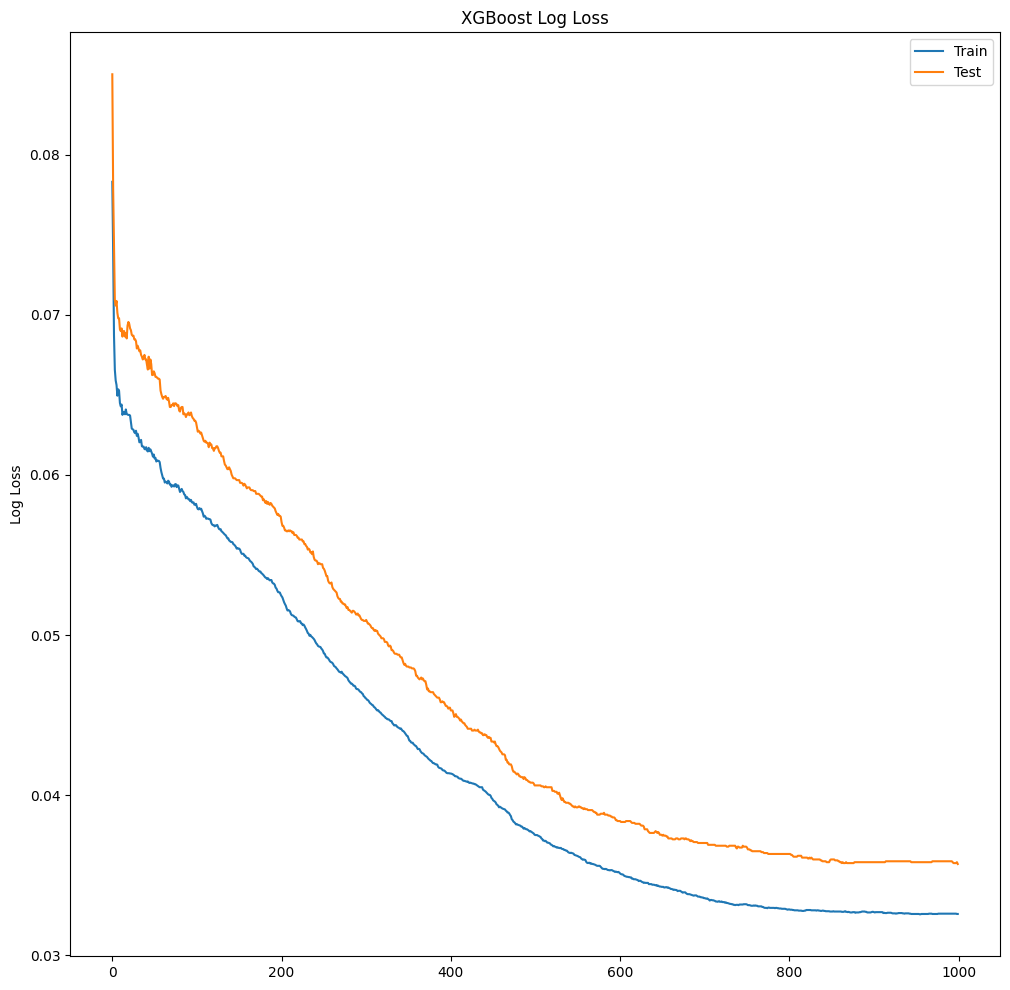

In [47]:
from matplotlib import pyplot as plot
%matplotlib inline

fig, ax = plot.subplots(figsize=(12,12))
ax.plot(results["validation_0"]["merror"], label="Train")
ax.plot(results["validation_1"]["merror"], label="Test")
ax.legend()
plot.ylabel("Log Loss")
plot.title("XGBoost Log Loss")
plot.show()

# plot.plot(results['validation_1']['merror'])
# plot.show()

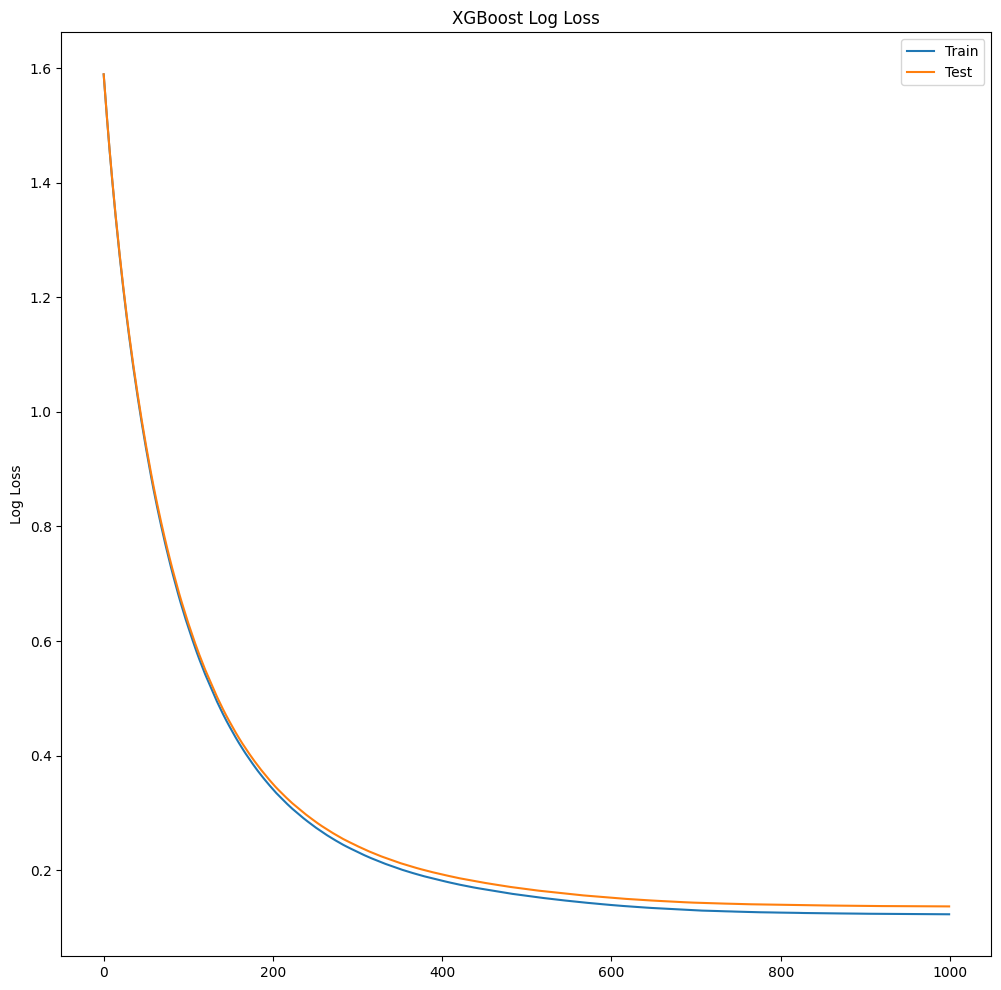

In [51]:
from matplotlib import pyplot as plot
%matplotlib inline

fig, ax = plot.subplots(figsize=(12,12))
ax.plot(results["validation_0"]["mlogloss"], label="Train")
ax.plot(results["validation_1"]["mlogloss"], label="Test")
ax.legend()
plot.ylabel("Log Loss")
plot.title("XGBoost Log Loss")
plot.show()

# plot.plot(results['validation_1']['merror'])
# plot.show()

In [22]:
from sklearn.metrics import accuracy_score
import time
# my_model.set_param({"predictor": "gpu_predictor"})
predictions = my_model.predict(test_x)

start = time.time()
y_pred  = my_model.predict(test_x)
print(time.time() - start)
accuracy = accuracy_score(test_y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))


0.3868439197540283
Accuracy: 96.43%
Mean Absolute Error : 0.07355292612727854


In [30]:
from sklearn.metrics import accuracy_score
import time
# my_model.set_param({"predictor": "gpu_predictor"})
# predictions = my_model.predict(test_x)

start = time.time()
y_pred  = my_model.predict(test_x)
print(time.time() - start)
accuracy = accuracy_score(test_y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

0.542273759841919
Accuracy: 96.43%
Mean Absolute Error : 0.07355292612727854


In [40]:
from xgboost import XGBClassifier
import time

model = XGBClassifier(silent=False,
                        scale_pos_weight=1,
                        learning_rate=0.01,
                        colsample_bytree = 0.4,
                        subsample = 0.8,
                        objective='binary:logistic',
                        n_estimators=1000,
                        reg_alpha = 0.3,
                        max_depth=4,
                        gamma=10,
                        n_jobs=5,
                        tree_method="gpu_hist")
                        # predictor="gpu_predictor")
model.load_model('xgb_ecg.model')
start = time.time()
y_pred  = model.predict(test_x)
print(time.time() - start)
# accuracy = accuracy_score(test_y, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

0.6148667335510254


In [39]:
from xgboost import XGBClassifier
import time

model = XGBClassifier(silent=False,
                        scale_pos_weight=1,
                        learning_rate=0.01,
                        colsample_bytree = 0.4,
                        subsample = 0.8,
                        objective='binary:logistic',
                        n_estimators=1000,
                        reg_alpha = 0.3,
                        max_depth=4,
                        gamma=10,
                        n_jobs=5,
                        tree_method="gpu_hist",
                        predictor="gpu_predictor")
model.load_model('xgb_ecg.model')
start = time.time()
y_pred  = model.predict(test_x)
print(time.time() - start)

0.8051068782806396
